# StaySharp Eye Detection

## Set up the Environment

### Importing Requirements

### Download Dataset

In [1]:
! pip install -q kaggle

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import zipfile

### Extract and Download the dataset

In [3]:
! kaggle datasets download prasadvpatil/mrl-dataset

Dataset URL: https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset
License(s): CC0-1.0
mrl-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
with zipfile.ZipFile('mrl-dataset.zip','r') as zip_ref:
  zip_ref.extractall('/content/')

In [5]:
PATH = '/content/train'

X = []
Y = []

for i in tqdm(glob(PATH+'/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(1)

for i in tqdm(glob(PATH+'/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(0)

100%|██████████| 2000/2000 [00:02<00:00, 903.70it/s]


In [6]:
X = np.array(X)
Y = np.array(Y)

### Augmenting and Splitting the dataset

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, shuffle=True)

print("Training data size (x_train):", len(x_train))
print("Training labels size (y_train):", len(y_train))
print("Test data size (x_test):", len(x_test))
print("Test labels size (y_test):", len(y_test))

Training data size (x_train): 3000
Training labels size (y_train): 3000
Test data size (x_test): 1000
Test labels size (y_test): 1000


## Creating Model

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
])

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(64, 64, 1)),
    tf.keras.layers.Rescaling(1.0 / 255),

    # Add the augmentation layers
    data_augmentation,

    # Convolutional layers
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195,393 (763.25 KB)

 Trainable params: 195,393 (763.25 KB)

 Non-trainable params: 0 (0.00 B)

### Setting Up Callbacks

In [10]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self,epoch,logs=None):
        if logs is None:
          logs = {}

        if logs.get('accuracy') >= 0.99 and logs.get('val_accuracy') >= 0.99:
            self.model.stop_training = True

            print("\nReached 99% train accuracy and 99% validation accuracy, so cancelling training!")

### Fit Model

In [11]:
history = model.fit(
    x_train, y_train,
    epochs = 30,
    batch_size = 32,
    validation_data = (x_test, y_test),
    verbose = 1,
    callbacks = [EarlyStoppingCallback()]
)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 265ms/step - accuracy: 0.6369 - loss: 0.5994 - val_accuracy: 0.8890 - val_loss: 0.2835
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - accuracy: 0.8576 - loss: 0.3010 - val_accuracy: 0.9560 - val_loss: 0.1160
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.8926 - loss: 0.2369 - val_accuracy: 0.9850 - val_loss: 0.0952
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.9449 - loss: 0.1375 - val_accuracy: 0.9890 - val_loss: 0.0426
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 263ms/step - accuracy: 0.9452 - loss: 0.1335 - val_accuracy: 0.9940 - val_loss: 0.0258
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - accuracy: 0.9121 - loss: 0.2194 - val_accuracy: 0.9630 - val_loss: 0.0881
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.9515 - loss: 0.1319 - val_accuracy: 0.9760 - val_loss: 0.0532
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - accuracy: 0.9642 - loss: 0.1026 - val_accu

### Evaluate the Model

In [12]:
model.evaluate(x_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9989 - loss: 0.0035


[0.005299639422446489, 0.9980000257492065]

### Visualization

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


Text(0.5, 25.722222222222214, 'Actual')

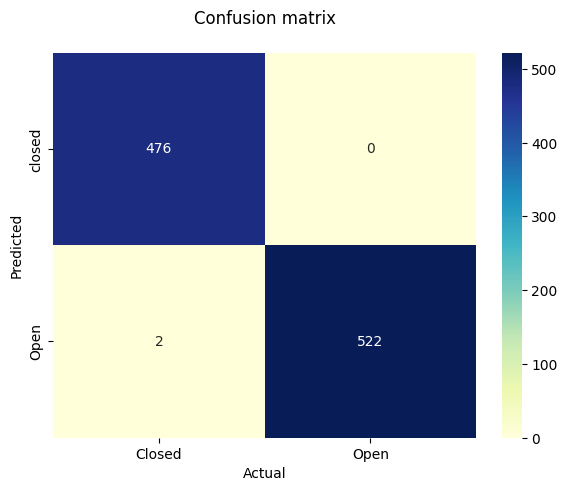

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

In [15]:
model.save('/content/StayAwake.keras')